In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, AveragePooling2D, BatchNormalization, MaxPool2D, Dropout
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from keras import backend as K

import numpy as np
import matplotlib.pyplot as plt

plt.style.use('ggplot')

Using TensorFlow backend.


In [2]:
batch_size = 256
num_classes = 10
epochs = 20

In [3]:
img_rows, img_cols = 28, 28

In [4]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [5]:
if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

In [6]:
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [7]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [8]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal',input_shape=input_shape))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',kernel_initializer='he_normal'))
model.add(MaxPool2D((2, 2)))
model.add(Dropout(0.20))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Conv2D(64, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), activation='relu',padding='same',kernel_initializer='he_normal'))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.25))
model.add(Dense(num_classes, activation='softmax'))

In [9]:
func = K.function([model.layers[0].input], [model.layers[-2].output])

In [10]:
lrs = []

In [11]:
K1 = 0.
K2 = 0.
beta1 = 0.9
beta2 = 0.999

In [22]:
def lr_schedule(epoch):
    """Learning Rate Schedule
    # Arguments
        epoch (int): The number of epochs
    # Returns
        lr (float32): learning rate
    """
    global K1, K2

    Kz = 0.  # max penultimate activation
    S = 0.
    
    sess = K.get_session()
    max_wt = 0.
    for weight in model.weights:
        norm = np.linalg.norm(weight.eval(sess))
        if norm > max_wt:
            max_wt = norm
    
    for i in range((len(x_train) - 1) // batch_size + 1):
        start_i = i * batch_size
        end_i = start_i + batch_size
        xb = x_train[start_i:end_i]
    	
        tmp = np.array(func([xb]))
        activ = np.linalg.norm(tmp)
        sq = np.linalg.norm(np.square(tmp))

        if sq > S:
            S = sq
        
        if activ > Kz:
            Kz = activ

    K_ = ((num_classes - 1) * Kz) / (num_classes * batch_size) #+ 1e-4 * max_wt
    S_ = (num_classes - 1) ** 2 / (num_classes * batch_size) ** 2 * S #+ 2e-4 * max_wt * ((num_classes - 1) * Kz) / (num_classes * batch_size)
    
    K1 = beta1 * K1 + (1 - beta1) * K_
    K2 = beta2 * K2 + (1 - beta2) * S_

    lr = (np.sqrt(K2) + K.epsilon()) / K1
    print('S =', S, ', K1 =', K1,', K2 =', K2, ', K_ =', K_, ', lr =', lr)
    lrs.append(lr)
    print('Epoch', epoch, 'LR =', lr)
    return lr

In [23]:
lr_scheduler = LearningRateScheduler(lr_schedule)

In [24]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(lr=1e-3),
              metrics=['accuracy'])

In [25]:
datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range=15, # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.1, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images

        # Compute quantities required for featurewise normalization
        # (std, mean, and principal components if ZCA whitening is applied).
datagen.fit(x_train)

In [26]:
model.fit_generator(datagen.flow(x_train, y_train, batch_size=batch_size),
                    steps_per_epoch=len(x_train) / batch_size,
                    epochs=20,
                    verbose=1,
                    validation_data=(x_test, y_test),
                    callbacks=[lr_scheduler])

Epoch 1/20
S = 377.14963 , K1 = 0.05617056906223295 , K2 = 4.661425757221881e-06 , K_ = 0.5617056906223297 , lr = 0.038438875730174175
Epoch 0 LR = 0.038438875730174175
235/234 [==============================] - 12s 51ms/step - loss: 0.5052 - acc: 0.8355 - val_loss: 0.0803 - val_acc: 0.9759
Epoch 2/20
S = 635.5947 , K1 = 0.10256808418035504 , K2 = 1.2512473079566855e-05 , K_ = 0.520145720243454 , lr = 0.03448828604149986
Epoch 1 LR = 0.03448828604149986
235/234 [==============================] - 12s 52ms/step - loss: 0.1291 - acc: 0.9596 - val_loss: 0.0669 - val_acc: 0.9806
Epoch 3/20
S = 289.10205 , K1 = 0.14222830669283865 , K2 = 1.607315184691717e-05 , K_ = 0.499170309305191 , lr = 0.02818871746676286
Epoch 2 LR = 0.02818871746676286
235/234 [==============================] - 12s 51ms/step - loss: 0.0992 - acc: 0.9698 - val_loss: 0.0492 - val_acc: 0.9861
Epoch 4/20
S = 377.49567 , K1 = 0.1854134446638822 , K2 = 2.072278136029493e-05 , K_ = 0.5740796864032746 , lr = 0.024552308941702

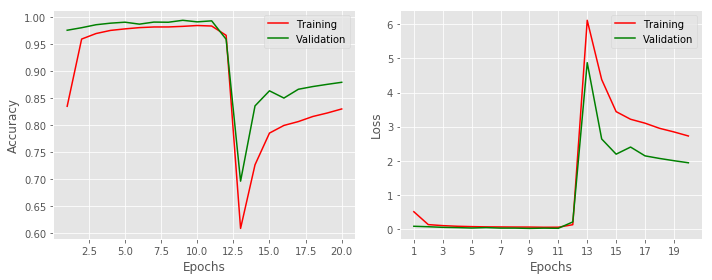

In [27]:
fig, ax = plt.subplots(ncols=2, figsize=(10, 4))
plt.xticks(range(1, 21, 2))

ax[0].set_ylabel('Accuracy');
ax[0].set_xlabel('Epochs');
lines = ax[0].plot(range(1, 21), model.history.history['acc'], 'r-',
                   range(1, 21), model.history.history['val_acc'], 'g-');
ax[0].legend(lines, ('Training', 'Validation'));

ax[1].set_ylabel('Loss')
ax[1].set_xlabel('Epochs')
lines = ax[1].plot(range(1, 21), model.history.history['loss'], 'r-',
                   range(1, 21), model.history.history['val_loss'], 'g-');
ax[1].legend(lines, ('Training', 'Validation'))

fig.tight_layout()

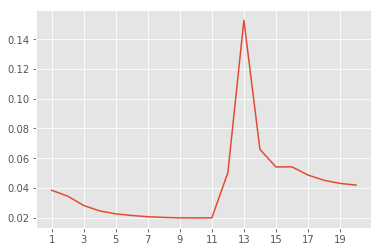

In [29]:
plt.xticks(range(1, 21, 2))
plt.plot(range(1, 21), lrs);